In [ ]:
!pip install torch torchvision torchaudio numpy pandas scipy scikit-learn librosa matplotlib tqdm datasets seaborn

In [ ]:
import os, numpy as np, pandas as pd, librosa, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, accuracy_score, precision_score, recall_score, f1_score,
                             precision_recall_curve)
from tqdm import tqdm
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset

In [8]:
dataset_hf = load_dataset("RS2002/WiFall")

os.makedirs("wifall_data/fall", exist_ok=True)
os.makedirs("wifall_data/no_fall", exist_ok=True)

for i, row in enumerate(dataset_hf["train"]):
    label = row["taget"].lower()
    arr_str = row["data"]
    arr = np.array([int(x) for x in arr_str[1:-1].split(', ')], dtype=np.float32)
    if label == "fall":
        np.save(f"wifall_data/fall/fall_{i}.npy", arr)
    else:
        np.save(f"wifall_data/no_fall/no_fall_{i}.npy", arr)

Repo card metadata block was not found. Setting CardData to empty.


In [9]:
class CSIDataset(Dataset):
    def __init__(self, root_dir):
        self.samples, self.labels = [], []
        self.label_map = {"no_fall": 0, "fall": 1}
        for label in ["no_fall", "fall"]:
            folder = os.path.join(root_dir, label)
            for f in os.listdir(folder):
                if f.endswith(".npy"):
                    self.samples.append(os.path.join(folder, f))
                    self.labels.append(self.label_map[label])

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        data = np.load(self.samples[idx])
        if data.ndim == 1: data = np.expand_dims(data, axis=0)
        if data.ndim == 2 and data.shape[0] > data.shape[1]: data = data.T
        # CNN expects 2D; LSTM will use sequence axis
        S = np.abs(librosa.stft(data.mean(axis=0), n_fft=128, hop_length=64))
        S = (S - S.mean()) / (S.std() + 1e-6)
        return torch.tensor(S[np.newaxis, :, :], dtype=torch.float32), torch.tensor(self.labels[idx])

In [10]:
dataset = CSIDataset("wifall_data")
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.labels)
train_ds, val_ds = torch.utils.data.Subset(dataset, train_idx), torch.utils.data.Subset(dataset, val_idx)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

In [13]:
class CNN_BiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d((2, 1)), # Adjusted kernel size
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d((2, 1))  # Adjusted kernel size
        )
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=2,
                            batch_first=True, dropout=0.3, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.mean(2)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.classifier(out)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_BiLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(25):
    model.train()
    total_loss = 0
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/25"):
        X, y = X.to(device), y.to(device)
        out = model(X)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/25:   0%|          | 0/23294 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=104
  warnings.warn(
Epoch 1/25: 100%|██████████| 23294/23294 [09:21<00:00, 41.47it/s]


Epoch 1 - Loss: 0.4690


Epoch 2/25: 100%|██████████| 23294/23294 [10:05<00:00, 38.49it/s]


Epoch 2 - Loss: 0.4358


Epoch 3/25: 100%|██████████| 23294/23294 [08:43<00:00, 44.51it/s]


Epoch 3 - Loss: 0.4178


Epoch 4/25: 100%|██████████| 23294/23294 [08:40<00:00, 44.79it/s]


Epoch 4 - Loss: 0.4079


Epoch 5/25: 100%|██████████| 23294/23294 [08:35<00:00, 45.14it/s]


Epoch 5 - Loss: 0.3998


Epoch 6/25: 100%|██████████| 23294/23294 [08:35<00:00, 45.20it/s]


Epoch 6 - Loss: 0.3942


Epoch 7/25: 100%|██████████| 23294/23294 [08:39<00:00, 44.85it/s]


Epoch 7 - Loss: 0.3891


Epoch 8/25: 100%|██████████| 23294/23294 [08:46<00:00, 44.23it/s]


Epoch 8 - Loss: 0.3851


Epoch 9/25: 100%|██████████| 23294/23294 [08:43<00:00, 44.48it/s]


Epoch 9 - Loss: 0.3819


Epoch 10/25: 100%|██████████| 23294/23294 [08:43<00:00, 44.51it/s]


Epoch 10 - Loss: 0.3785


Epoch 11/25: 100%|██████████| 23294/23294 [08:42<00:00, 44.58it/s]


Epoch 11 - Loss: 0.3760


Epoch 12/25: 100%|██████████| 23294/23294 [08:42<00:00, 44.61it/s]


Epoch 12 - Loss: 0.3735


Epoch 13/25: 100%|██████████| 23294/23294 [08:37<00:00, 44.98it/s]


Epoch 13 - Loss: 0.3722


Epoch 14/25: 100%|██████████| 23294/23294 [08:41<00:00, 44.66it/s]


Epoch 14 - Loss: 0.3690


Epoch 15/25: 100%|██████████| 23294/23294 [08:43<00:00, 44.47it/s]


Epoch 15 - Loss: 0.3672


Epoch 16/25: 100%|██████████| 23294/23294 [08:51<00:00, 43.86it/s]


Epoch 16 - Loss: 0.3656


Epoch 17/25: 100%|██████████| 23294/23294 [08:45<00:00, 44.31it/s]


Epoch 17 - Loss: 0.3641


Epoch 18/25: 100%|██████████| 23294/23294 [08:51<00:00, 43.82it/s]


Epoch 18 - Loss: 0.3628


Epoch 19/25: 100%|██████████| 23294/23294 [08:41<00:00, 44.64it/s]


Epoch 19 - Loss: 0.3605


Epoch 20/25: 100%|██████████| 23294/23294 [08:37<00:00, 45.03it/s]


Epoch 20 - Loss: 0.3597


Epoch 21/25: 100%|██████████| 23294/23294 [08:42<00:00, 44.56it/s]


Epoch 21 - Loss: 0.3584


Epoch 22/25: 100%|██████████| 23294/23294 [08:44<00:00, 44.42it/s]


Epoch 22 - Loss: 0.3569


Epoch 23/25: 100%|██████████| 23294/23294 [08:46<00:00, 44.24it/s]


Epoch 23 - Loss: 0.3555


Epoch 24/25: 100%|██████████| 23294/23294 [08:44<00:00, 44.40it/s]


Epoch 24 - Loss: 0.3540


Epoch 25/25: 100%|██████████| 23294/23294 [08:43<00:00, 44.48it/s]

Epoch 25 - Loss: 0.3528



Accuracy: 83.48%  Precision: 79.97%  Recall: 89.40%
Specificity: 77.55%  Sensitivity: 89.40%
F1-Score: 84.43%  AUC: 91.92%


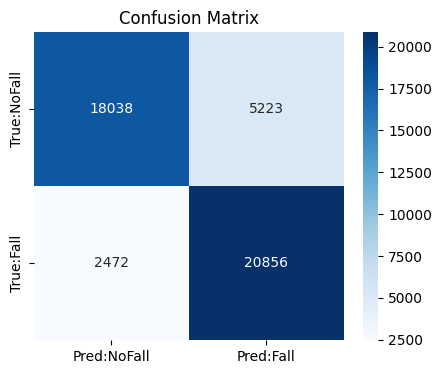

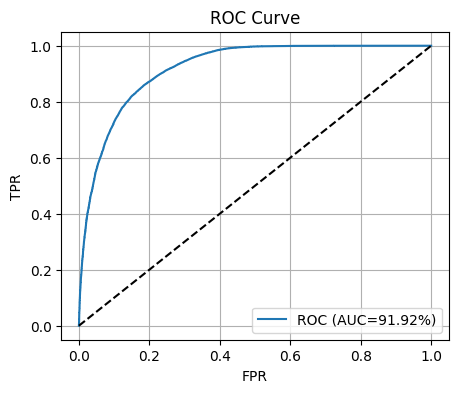

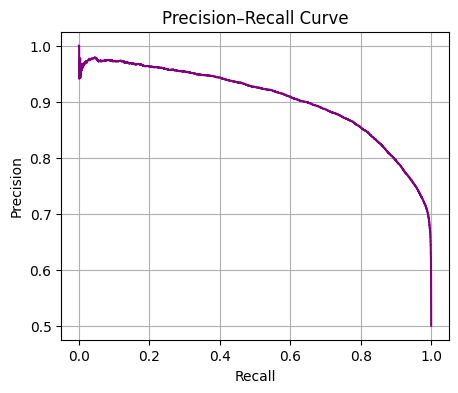

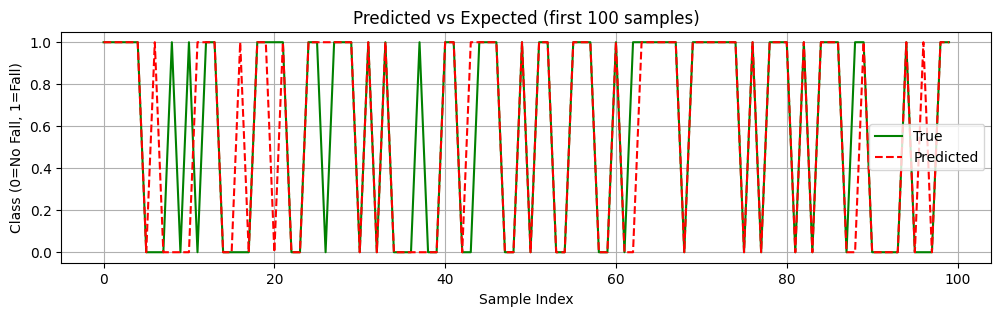

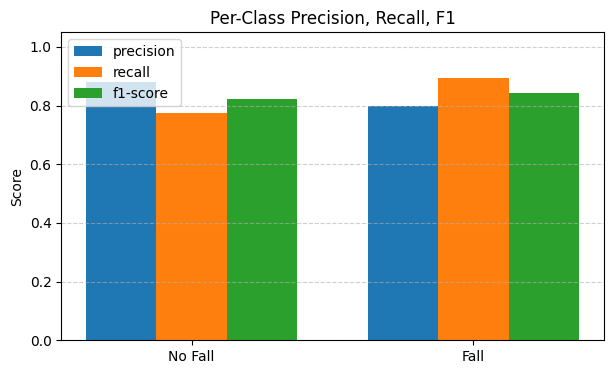

In [15]:
model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        out = model(X)
        probs = torch.softmax(out, dim=1)[:, 1]
        preds = torch.argmax(out, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

acc = accuracy_score(y_true, y_pred) * 100
prec = precision_score(y_true, y_pred) * 100
rec = recall_score(y_true, y_pred) * 100
f1 = f1_score(y_true, y_pred) * 100
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = (tn / (tn + fp)) * 100
sensitivity = (tp / (tp + fn)) * 100
auc = roc_auc_score(y_true, y_prob) * 100
fpr, tpr, _ = roc_curve(y_true, y_prob)
precisions, recalls, _ = precision_recall_curve(y_true, y_prob)

print(f"\nAccuracy: {acc:.2f}%  Precision: {prec:.2f}%  Recall: {rec:.2f}%")
print(f"Specificity: {specificity:.2f}%  Sensitivity: {sensitivity:.2f}%")
print(f"F1-Score: {f1:.2f}%  AUC: {auc:.2f}%")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred:NoFall", "Pred:Fall"],
            yticklabels=["True:NoFall", "True:Fall"])
plt.title("Confusion Matrix"); plt.show()

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.2f}%)"); plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(); plt.title("ROC Curve"); plt.show()

plt.figure(figsize=(5,4))
plt.plot(recalls, precisions, color="purple"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve"); plt.grid(); plt.show()

plt.figure(figsize=(12,3))
plt.plot(y_true[:100], 'g-', label="True"); plt.plot(y_pred[:100], 'r--', label="Predicted")
plt.title("Predicted vs Expected (first 100 samples)")
plt.xlabel("Sample Index"); plt.ylabel("Class (0=No Fall, 1=Fall)")
plt.legend(); plt.grid(); plt.show()

report = classification_report(y_true, y_pred, output_dict=True)
classes, metrics = ["No Fall", "Fall"], ["precision", "recall", "f1-score"]
vals = [[report[c][m] for c in ['0','1']] for m in metrics]
plt.figure(figsize=(7,4))
x = np.arange(len(classes)); bw = 0.25
for i,m in enumerate(metrics): plt.bar(x+i*bw, vals[i], width=bw, label=m)
plt.xticks(x+bw, classes); plt.ylim(0,1.05)
plt.ylabel("Score"); plt.title("Per-Class Precision, Recall, F1")
plt.legend(); plt.grid(axis="y", linestyle="--", alpha=0.6); plt.show()